<a href="https://colab.research.google.com/github/Elisa1999/CS542/blob/main/pset3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 3: CNNs [75 pts]



**Note**: The following has been verified to work with TensorFlow 2.0

\* Adapted from official TensorFlow&trade; tour guide.

TensorFlow is a powerful library for doing large-scale numerical computation. One of the tasks at which it excels is implementing and training deep neural networks. In this assignment you will learn the basic building blocks of a TensorFlow model while constructing a deep convolutional MNIST classifier.

What you are expected to implement in this tutorial:

* Create a softmax regression function that is a model for recognizing MNIST digits, based on looking at every pixel in the image

* Use Tensorflow to train the model to recognize digits by having it "look" at thousands of examples

* Check the model's accuracy with MNIST test data

* Build, train, and test a multilayer convolutional neural network to improve the results


# Part 1: Coding [50 pts]

## Data

After importing tensorflow, we can download the MNIST dataset with the built-in TensorFlow/Keras method.

In [ ]:
import os

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

os.environ['OMP_NUM_THREADS'] = '1'
tf.__version__

'2.8.0'

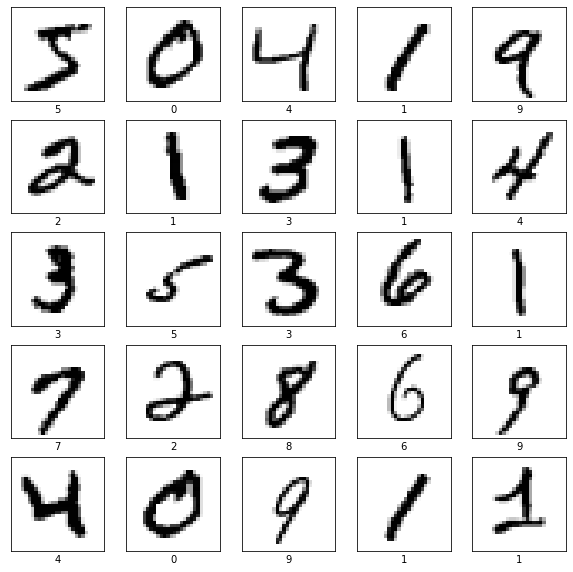

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build the CNN

In this part we will build a customized TF2 Keras model. As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. For MNIST, you will configure our CNN to process inputs of shape (28, 28, 1), which is the format of MNIST images. You can do this by passing the argument input_shape to our first layer.

The overall architecture should be:

```
Model: "customized_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_2 (Conv2D)            multiple                  320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  18496     
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  7930880   
_________________________________________________________________
dense_3 (Dense)              multiple                  10250     
=================================================================
Total params: 7,959,946
Trainable params: 7,959,946
Non-trainable params: 0
_________________________________________________________________
```
### First Convolutional Layer [5 pts]

We can now implement our first layer. The convolution will compute 32 features for each 3x3 patch. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels.

### Max Pooling Layer [5 pts]

We stack max pooling layer after the first convolutional layer. These pooling layers will perform max pooling for each 2x2 patch.

### Second Convolutional Layer [5 pts]

In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 3x3 patch.


### Fully Connected Layers [10 pts]

Now that the image size has been reduced to 11x11, we add a fully-connected layer with 128 neurons to allow processing on the entire image. We reshape the tensor from the second convolutional layer into a batch of vectors before the fully connected layer.

The output layer should also be implemented via a fully connect layer.


### Complete the Computation Graph [15 pts]

Please complete the following function:

```def call(self, inputs, training=None, mask=None):```

To apply the layer, we first reshape the input to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels (which is 1).

We then convolve the reshaped input with the first convolutional layer and then the max pooling followed by the second convolutional layer. These convolutional layers and the pooling layer will reduce the image size to 11x11.

### Dropout Layer [5 pts]
Please add dropouts during training before each fully connected layers, as this helps avoid overfitting during training.
https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

In [ ]:
class CustomizedCNN(tf.keras.models.Model):

    def __init__(self, *args, **kwargs):
        #raise NotImplementedError('Implement Using Keras Layers.')
        super().__init__()
        self.conv2d = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu')
        self.max_pooling2d = tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2)
        self.conv2d_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(units = 128, activation = 'sigmoid')
        self.dense_1 = tf.keras.layers.Dense(units = 10)
        self.dropout = tf.keras.layers.Dropout(0.5)

        

    def call(self, inputs, training= None, mask=None):
        #raise NotImplementedError('Build the CNN here.')
        x = self.conv2d(inputs)
        x = self.max_pooling2d(x) 
        x = self.conv2d_1(x)
        x = self.flatten(x)
        if training: 
           x = self.dropout(x, training=training)
        x = self.dense(x)
        if training: 
           x = self.dropout(x, training=training)
        return self.dense_1(x)

        


        

## Build the Model

In [ ]:
model = CustomizedCNN()
model.build(input_shape=(None, 28, 28,1))
model.summary()

Model: "customized_cnn_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           multiple                  320       
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           multiple                  18496     
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  991360    
                                                                 
 dense_5 (Dense)             multiple                  1290      
                                                  

We can specify a loss function just as easily. Loss indicates how bad the model's prediction was on a single example; we try to minimize that while training across all the examples. Here, our loss function is the cross-entropy between the target and the softmax activation function applied to the model's prediction. As in the beginners tutorial, we use the stable formulation:

In [ ]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

## Train and Evaluate the Model [5 pts]

We will use a more sophisticated ADAM optimizer instead of a Gradient Descent Optimizer.

Feel free to run this code. Be aware that it does 10 training epochs and may take a while (possibly up to half an hour), depending on your processor.

The final test set accuracy after running this code should be approximately 98.7%  -- not state of the art, but respectable.

We have learned how to quickly and easily build, train, and evaluate a fairly sophisticated deep learning model using TensorFlow.

In [ ]:
#dealth with train
x_train = np.expand_dims(train_images, axis=-1) # <--- add batch axis
x_train = x_train.astype('float32') / 255
y_train = tf.convert_to_tensor(train_labels)
#deal with test
x_test = np.expand_dims(test_images, axis=-1)
x_test = x_test.astype('float32') / 255
y_test = tf.convert_to_tensor(test_labels)


#raise NotImplementedError('Update correct arguments for the fit method below.')
history = model.fit(x = x_train, y = train_labels, validation_split = 0.2 , epochs = 10) # Use correct args here.

Epoch 1/10
1500/1500 [==============================] - 63s 42ms/step - loss: 0.2540 - accuracy: 0.9286 - val_loss: 0.0742 - val_accuracy: 0.9788
Epoch 2/10
1500/1500 [==============================] - 62s 42ms/step - loss: 0.0978 - accuracy: 0.9715 - val_loss: 0.0500 - val_accuracy: 0.9857
Epoch 3/10
1500/1500 [==============================] - 62s 41ms/step - loss: 0.0730 - accuracy: 0.9785 - val_loss: 0.0457 - val_accuracy: 0.9866
Epoch 4/10
1500/1500 [==============================] - 62s 41ms/step - loss: 0.0617 - accuracy: 0.9809 - val_loss: 0.0397 - val_accuracy: 0.9871
Epoch 5/10
1500/1500 [==============================] - 63s 42ms/step - loss: 0.0515 - accuracy: 0.9847 - val_loss: 0.0360 - val_accuracy: 0.9893
Epoch 6/10
1500/1500 [==============================] - 62s 41ms/step - loss: 0.0451 - accuracy: 0.9864 - val_loss: 0.0347 - val_accuracy: 0.9901
Epoch 7/10
1500/1500 [==============================] - 62s 41ms/step - loss: 0.0433 - accuracy: 0.9866 - val_loss: 0.0332 -

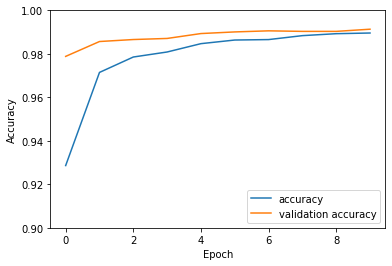

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(test_acc)

313/313 [==============================] - 4s 12ms/step - loss: 0.0254 - accuracy: 0.9915
0.9915000200271606


# Part 2: Written [22 pts]


**2.1 [4pts]** True/False, and why? Training a neural network from scratch takes significantly less time than using a pre-trained network and fine-tuning the final layers on the new task at hand. 

False. Training a neural network from scratch will take significantly more than than using a pre-trained network. 

**2.2 [2pts]**  Which of the above approaches in 2.1 is referred to as *Transfer Learning*?

Using a pre-trained network and fine-tuning the final layers on the new task

**2.3 [4pts]**  List two ways to downsize feature maps in convolutional neural networks.

The feature maps of a CNN capture the result of applying the filters to an input image. We can use pooling including max-pooling or mean pooling to downside feature maps. Or we can use stride > 1 in the convolution layer. 


**2.4 [4pts]**  List four techniques that help a model avoid overfitting briefly explaining each.

We can add L2 or L1 regularization in the cost function to prevent overfitting. We also can augment our exisiting data set, for example, mirror-image all images or injecting noise to training data to make the model generlize better. What's more, we can set an early stop point to prevent overfitting. We can implement dropout which drops neurons having strong evidence to forces a network to learn alternative paths in order to maintain loss minimization. 

**2.5 [2pts]** Read the following on convolutions: https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1. What is padding? And what does it help us achieve.

Padding is adding additional and 'fake' pixels to the edges of the input to fix the boundary effect. Usually the value is 0. The kernel when sliding can allow the original edge pixels to be at its center, while extending into the fake pixels beyond the edge, producing an output the same size as the input.

**2.6 [2pts]** How does back-propagation in RNNs differ from back-propagation in CNNs?

In RNN, we have back-propagation through time. We need to sum the partial derivative of every error. However, inback-propogation in CNN, we only mutiply the local gradient and upstream gradient. 


**2.7 [4pts]** Explain two different ways to reduce the dimensionality of 1024D feature vectors extracted from a CNN for images.

1. We can implement K-means to compress the image. We cluster each {R, G, B} pixel value into k clusters and replace each vector by its cluster's index. 
2. We can also use auto-encoder to reduce the dimensionality of the feature vectors.

**2.8 [3pts]** What is an auto-encoder? What can it be used for?

Auto-encoder neural network is unsupervised learning algorithm that applies backpropogation, setting the target values to be equal to the inputs. We usually used auto-encoder for feature extraction with reduction of dimensionality.